# Sampling

**Goal:** ...
  
This notebook is divided in two parts:
* **1. Bla**

In [2]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [13]:
summary = Summary()

## Unified by key

In [3]:
data = Impact_Wrapper('../../../data/annotated_final_IMPACT_mutations_180508.txt', 'is_artefact', shuffle=True)

In [4]:
def get_random_sample(x, max_number=3):
    if x.shape[0] > max_number:
        return x.sample(max_number, random_state=42).tolist()
    else:
        return x.tolist()

aggregation = {
    'mut_key': 'count',
    'sample_mut_key': [('sample_mut_key', lambda x: x.tolist()),
                       ('selected_sample_mut_key', get_random_sample)]
}

dd = data.impact.groupby('mut_key').aggregate(aggregation)
dd.head(10)

mut_key  \
                                   count   
mut_key                                    
10_104263912_G_A                       1   
10_104263932_GCGCCCCCGGCCCCACC_-       2   
10_104263935_C_-                       1   
10_104263935_C_T                       1   
10_104263941_G_A                       3   
10_104263952_C_-                       1   
10_104263959_C_T                       1   
10_104263973_-_C                      12   
10_104263974_C_-                       3   
10_104263979_C_A                       1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sample_mut_key  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sample_mut_key   
mut_key                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
10_104263912_G_A                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0004423-T01-IM5_10_104263912_G_A]   
10_104263932_GCGCCCCCGGCCCCACC_-                                                                                                                                                                                                                                                                                                                                          [P-0001027-T01-IM3_10_104263932_GCGCCCCCGGCCCCACC_-, P-0015687-T01-IM6_10_104263932_GCGCCCCCGGCCCCACC_-]   
10_104263935_C_-                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0015938-T01-IM6_10_104263935_C_-]   
10_104263935_C_T                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0012445-T01-IM5_10_104263935_C_T]   
10_104263941_G_A                                                                                                                                                          

In [6]:
selected_sample_mut_key = unlist([key for key in dd['sample_mut_key', 'selected_sample_mut_key']])

print(data.impact.shape)
data.impact = data.impact[data.impact.sample_mut_key.isin(selected_sample_mut_key)].copy()
print(data.impact.shape)

(194211, 64)
(160752, 64)


In [8]:
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']

X, y = data.process(features).get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (160752, 45) | y: (160752,)


,count_,freq_
False,155564,96.8%
True,5188,3.2%


In [9]:
job_unified = Selene_Job('ki_unified', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')
job_unified.load_data(X, y)

➞ mkdir on local computer ../ssh_remote_jobs/job_ki_unified


<span style="color:green">Job < ki_unified >: </span>✅ created

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_ki_unified


<span style="color:green">Job < ki_unified >: </span>✅ data loaded

In [54]:
job_unified = Selene_Job('ki_unified', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < ki_unified >: </span>✅ job found and reloaded

In [11]:
%%writefile {job_unified.script_path}

# load the ml_tools functions
%run ../../metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# set cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=6, n_estimators=500))
metrics = Metrics(model, X, y, cv_strategy, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ../ssh_remote_jobs/job_ki_unified/script.ipy


In [12]:
job_unified.run(n_jobs=20, short_job=True)

➞ scp ../ssh_remote_jobs/job_ki_unified to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  841   129.2KB/s   00:00    
X.pkl                                         100%   37MB  18.3MB/s   00:02    
y.pkl                                         100% 2669KB  12.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_ki_unified
Job <28995944> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ki_unified -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ki_unified >: </span>✅ submitted<br>

In [56]:
job_unified.get_results()

<span style="color:green">Job < ki_unified >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_ki_unified to ../ssh_remote_jobs/job_ki_unified
metrics.pkl                                   100%   53MB   8.3MB/s   00:06    
job_output.txt                                100% 1372    89.1KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.477 ± 0.015
▴ Mean roc_auc          : 0.856 ± 0.007
▴ Mean precision        : 0.128 ± 0.003
▴ Mean recall           : 0.729 ± 0.014
▴ Mean f1               : 0.218 ± 0.005
▴ Mean accuracy         : 0.831 ± 0.004


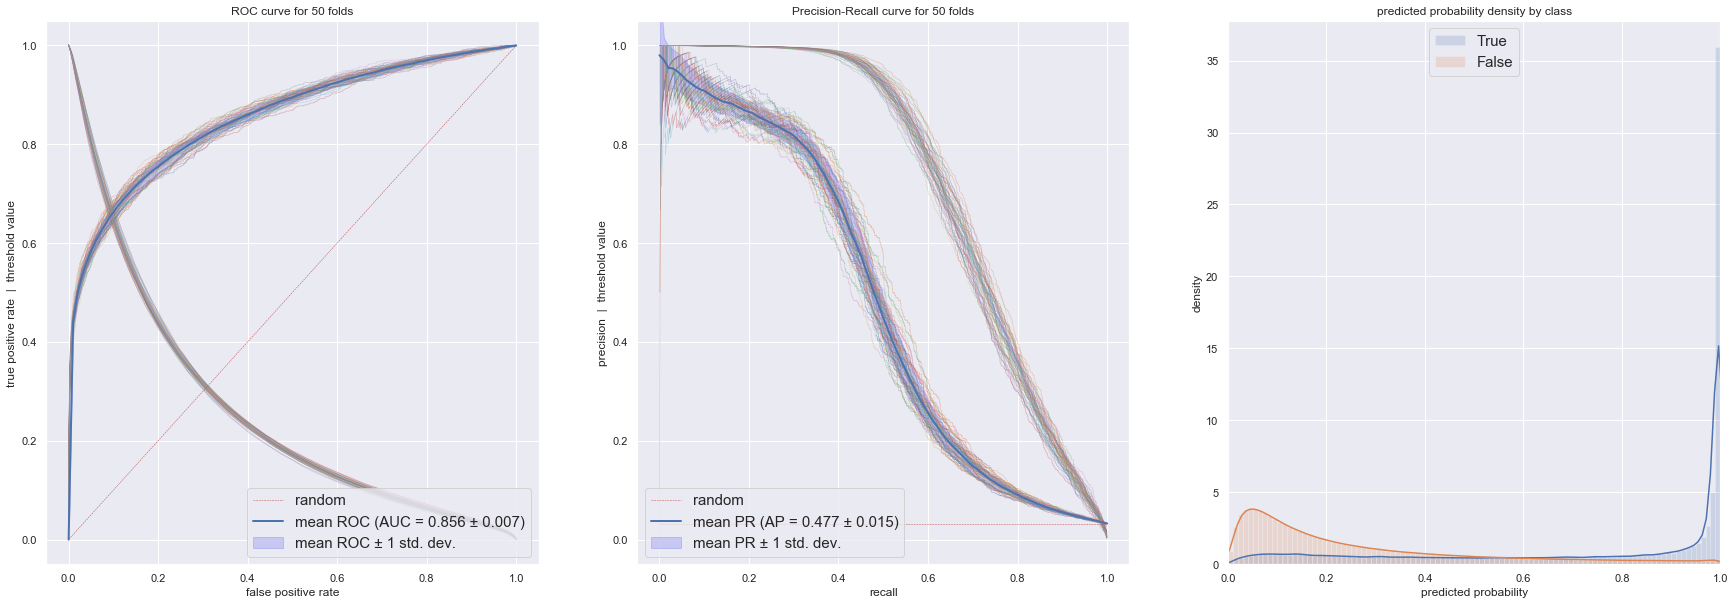

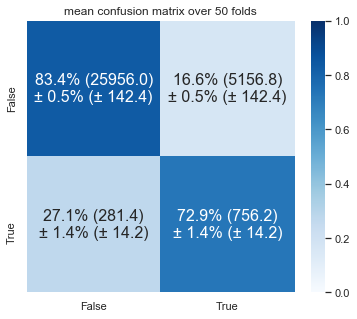

In [57]:
job_unified.metrics.print_mean()
job_unified.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_unified.metrics.plot_mean_confusion_matrix()

## Not unified

In [63]:
data = Impact_Wrapper('../../../data/annotated_final_IMPACT_mutations_180508.txt', 'is_artefact', shuffle=True)

In [64]:
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']

X, y = data.process(features).get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (194211, 45) | y: (194211,)


,count_,freq_
False,187012,96.3%
True,7199,3.7%


In [65]:
X = X.drop(index_to_drop)
y = y.drop(index_to_drop)
Impact_Wrapper.print_info(X, y)

X: (192200, 45) | y: (192200,)


,count_,freq_
False,187012,97.3%
True,5188,2.7%


In [50]:
job = Selene_Job('ki_baseline', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')
job.load_data(X, y, path_to_script=job_unified.script_path)

➞ mkdir on local computer ../ssh_remote_jobs/job_ki_baseline


<span style="color:green">Job < ki_baseline >: </span>✅ created

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_ki_baseline


<span style="color:green">Job < ki_baseline >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_ki_unified/script.ipy to ../ssh_remote_jobs/job_ki_baseline


<span style="color:green">Job < ki_baseline >: </span>✅ script loaded

In [51]:
job = Selene_Job('ki_baseline', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < ki_baseline >: </span>✅ job found and reloaded

In [52]:
job.run(n_jobs=20, short_job=True)

➞ scp ../ssh_remote_jobs/job_ki_baseline to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  841   145.9KB/s   00:00    
X.pkl                                         100%   44MB  15.8MB/s   00:02    
y.pkl                                         100% 3191KB  17.3MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_ki_baseline
Job <28996107> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ki_baseline -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ki_baseline >: </span>✅ submitted<br>

In [58]:
job.get_results()

<span style="color:green">Job < ki_baseline >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_ki_baseline to ../ssh_remote_jobs/job_ki_baseline
metrics.pkl                                   100%   62MB  10.8MB/s   00:05    
job_output.txt                                100% 1375   133.2KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.527 ± 0.019
▴ Mean roc_auc          : 0.889 ± 0.006
▴ Mean precision        : 0.141 ± 0.003
▴ Mean recall           : 0.762 ± 0.013
▴ Mean f1               : 0.238 ± 0.005
▴ Mean accuracy         : 0.868 ± 0.003


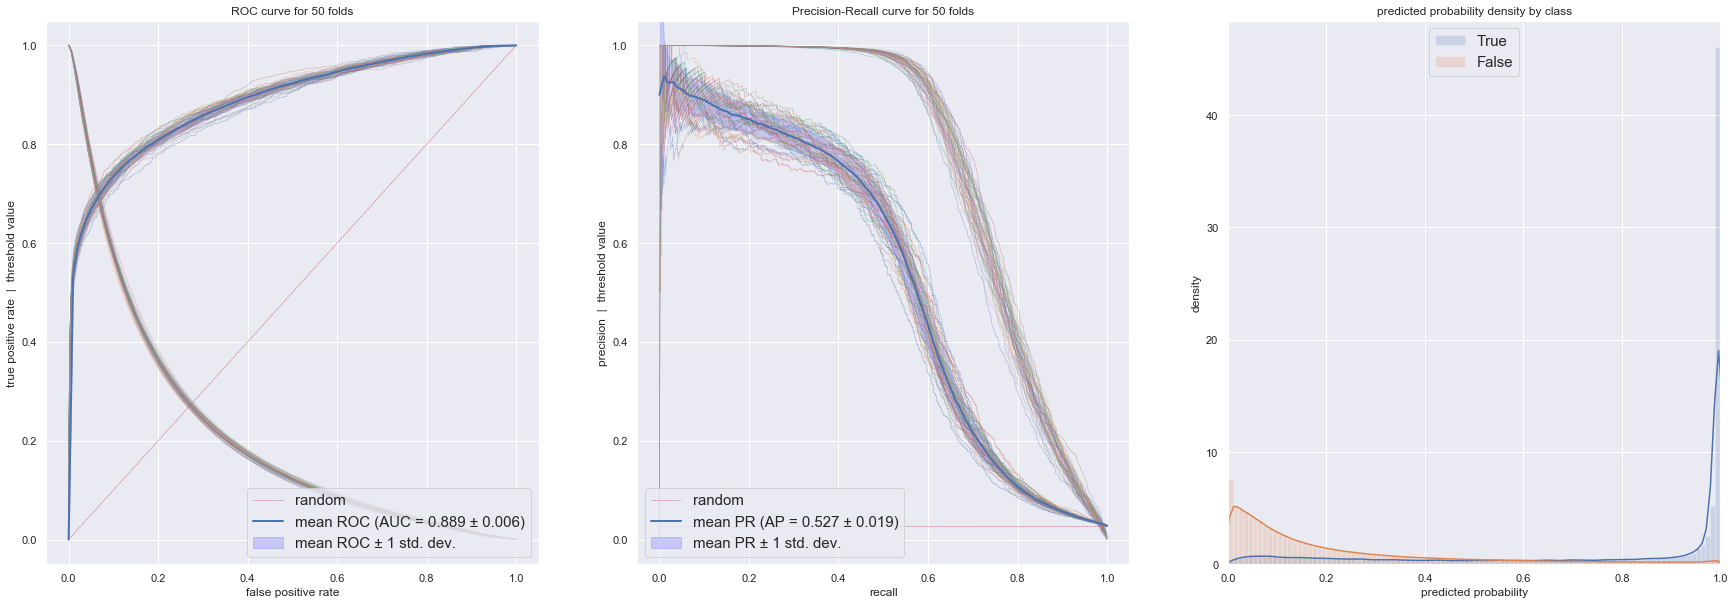

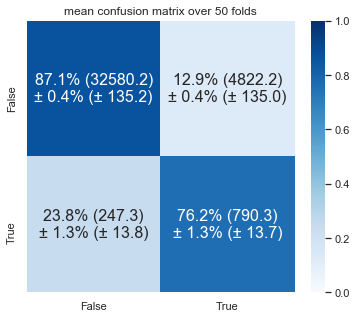

In [59]:
job.metrics.print_mean()
job.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job.metrics.plot_mean_confusion_matrix()

## Summary

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
ki_unified,0.477,0.856,0.128,0.729,0.218,0.831
baseline,0.527,0.889,0.141,0.762,0.238,0.868


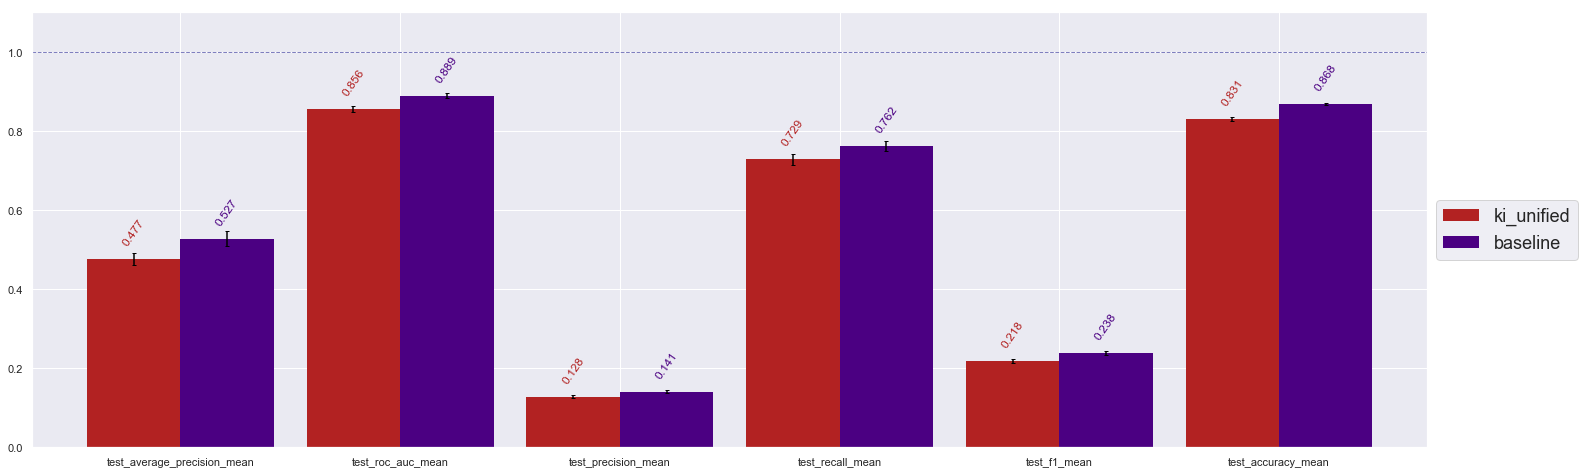

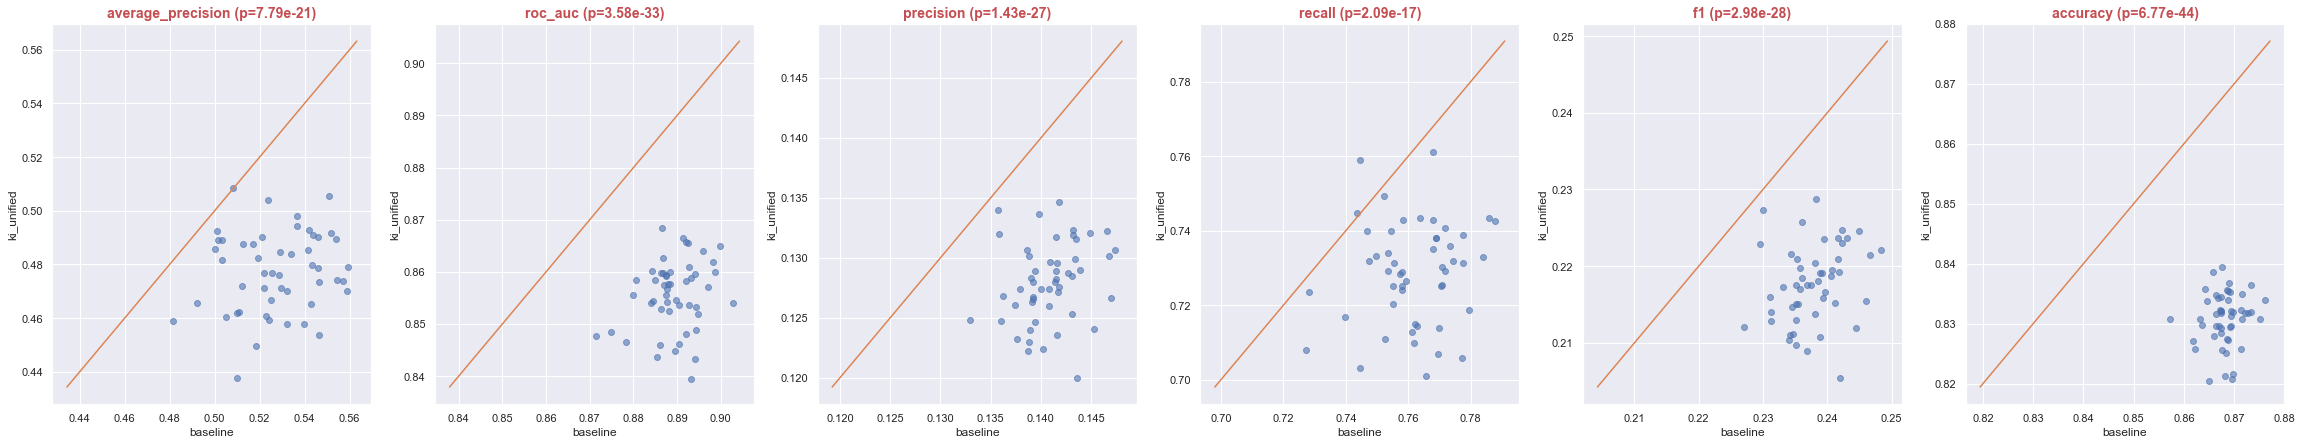

In [61]:
summary = Summary()
summary.add(job_unified.metrics, job_unified.job_id, 'firebrick')
summary.add(job.metrics, 'baseline', 'indigo')
summary.display()
summary.plot()
summary.plot_2_vs_2('baseline', job_unified.job_id)